# 2D Potential u(theta, phi)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from lib.renormalization_np import track_rg_flow

def plot_potential_vs_relative_angle(J1, J2, M, n_max=20, n_rg_steps=20, fixed_phi_values=None, b=2, d=2):
    """
    Plot the potential u (exponentiated Hamiltonian) versus a single relative angle
    at the RG sink, with normalized y-axis.
    
    Args:
        J1: First 2-spin coupling constant
        J2: Second 2-spin coupling constant
        M: 4-spin coupling constant
        n_max: Maximum Fourier mode
        n_rg_steps: Number of RG steps to reach the sink
        fixed_phi_values: List of phi values to fix when plotting u vs theta
                          If None, uses [0, π/4, π/2, 3π/4, π]
        b: Length rescaling factor
        d: Dimension
    
    Returns:
        Matplotlib figure
    """
    # Track RG flow to get coefficients at the sink
    flow_history = track_rg_flow(J1, J2, M, b, d, n_max, n_rg_steps)
    
    # Get the final coefficients (at the sink)
    final_coeffs = flow_history[-1]
    
    # Create a range of theta values from 0 to π
    theta_values = np.linspace(0, np.pi, 200)
    
    # If no phi values provided, use these defaults
    if fixed_phi_values is None:
        fixed_phi_values = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Store all u_values to find global maximum for normalization
    all_u_values = []
    
    # Calculate potential for each fixed phi value
    u_values_dict = {}
    for phi in fixed_phi_values:
        # Calculate potential u for each theta with fixed phi
        u_values = np.zeros_like(theta_values, dtype=complex)
        
        # Reconstruct potential from Fourier coefficients
        for n in range(-n_max, n_max + 1):
            for m in range(-n_max, n_max + 1):
                n_idx = n + n_max
                m_idx = m + n_max
                u_values += final_coeffs[n_idx, m_idx] * np.exp(1j * (n*theta_values + m*phi))
        
        # Take absolute value or real part as appropriate
        u_real = np.abs(u_values)  # Using absolute value as potential is real but complex numbers used in computation
        
        # Store for later plotting (after normalization)
        u_values_dict[phi] = u_real
        all_u_values.extend(u_real)
    
    # Find global maximum for normalization
    global_max = max(all_u_values)
    
    # Plot normalized potential for each fixed phi value
    for phi, u_real in u_values_dict.items():
        # Normalize
        u_normalized = u_real / global_max
        
        # Plot the curve for this phi value
        if phi == 0:
            label = 'φ = 0'
        elif phi == np.pi/4:
            label = 'φ = π/4'
        elif phi == np.pi/2:
            label = 'φ = π/2'
        elif phi == 3*np.pi/4:
            label = 'φ = 3π/4'
        elif phi == np.pi:
            label = 'φ = π'
        else:
            label = f'φ = {phi:.2f}'
            
        ax.plot(theta_values, u_normalized, label=label, linewidth=2)
    
    # Add labels and title
    ax.set_xlabel('Relative Angle θ', fontsize=14)
    ax.set_ylabel('Normalized Potential u(θ,φ)', fontsize=14)
    ax.set_title(f'Normalized Potential u vs Relative Angle θ at RG Sink\n(J1={J1}, J2={J2}, M={M})', 
                 fontsize=14)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    # Set x-axis ticks to show in terms of π
    ax.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    ax.set_xticklabels(['0', 'π/4', 'π/2', '3π/4', 'π'])
    
    # Set axis limits
    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, 1.05)  # Add a little space at the top
    
    fig.tight_layout()
    
    return fig

100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


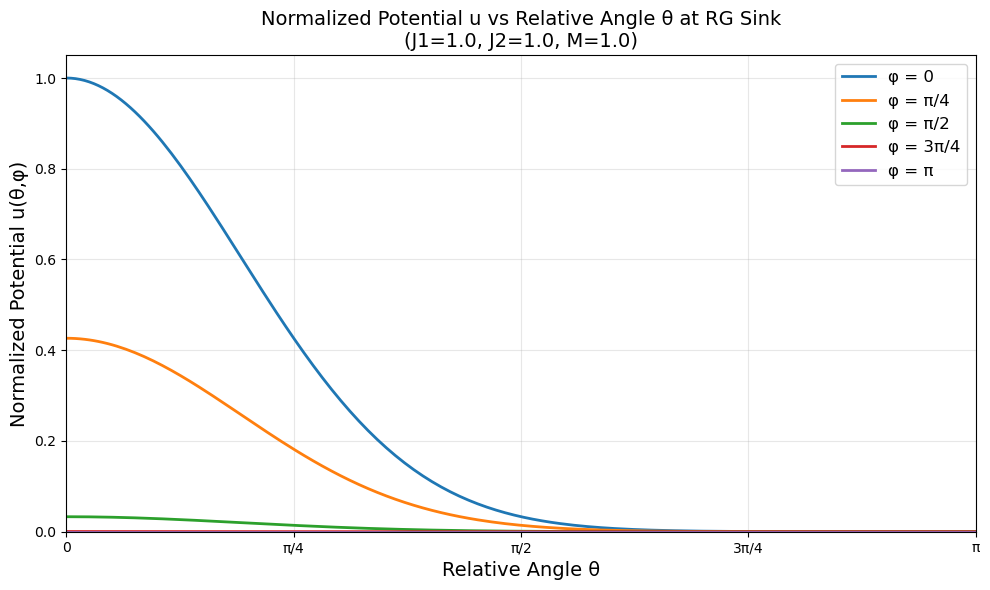

In [18]:
from renormalization_np import track_rg_flow

# Define parameters
J1 = 1.0    # First 2-spin coupling
J2 = 1.0    # Second 2-spin coupling (same as J1 for symmetric case)
M = 1.0     # 4-spin coupling

# Analyze RG flow
analyze_rg_flow(J1, J2, M, n_max=20, n_rg_steps=10, b=3, d=2)

# Plot potential versus relative angle
fixed_phi_values = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
fig = plot_potential_vs_relative_angle(J1, J2, M, n_max=20, n_rg_steps=15, 
                                      fixed_phi_values=fixed_phi_values, b=3, d=2)

#plt.savefig(f"potential.png", dpi=100, bbox_inches='tight')
plt.show()

# 2D Potential u(theta), Energy

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_potential_energy(coeffs_list, J_M_list=None, mode='potential', angle_unit='radians',
                             angle_range_degrees=(0, 180), title=None, n_points=500, figsize=(10, 6),
                             normalize=True, epsilon=1e-15, save_path=None):
    """
    Plot 2D potential or energy for a single angle, with support for multiple parameter sets.
    Works with both numpy and mpmath coefficient arrays.
    
    Args:
        coeffs_list: List of coefficient arrays, each shape (2*n_max+1, 2*n_max+1)
        J_M_list: List of tuples [(J1, J2, M), ...] for labeling (default: None)
        mode: 'potential' to plot u(θ) or 'energy' to plot -beta*V(θ) (default: 'potential')
        angle_unit: 'radians' for [0,π] or 'degrees' for [0,180] (default: 'radians')
        title: Title for the plot (default: None)
        n_points: Number of points for the angle grid (default: 500)
        figsize: Figure size (width, height) in inches (default: (10, 6))
        normalize: Whether to normalize the potential (default: True)
        epsilon: Small value to avoid log(0) in energy mode (default: 1e-15)
        save_path: Path to save the figure (default: None)
        
    Returns:
        fig: Matplotlib figure object
    """
    # Helper function to detect if a value is an mpmath object
    def is_mpmath(x):
        return hasattr(x, '_mpf_') or hasattr(x, '_mpc_')
    
    # Helper function to convert mpmath to float/complex
    def to_numpy_type(x):
        if is_mpmath(x):
            if hasattr(x, '_mpc_'):  # Complex mpmath
                return complex(x)
            else:  # Real mpmath
                return float(x)
        return x  # Already numpy type
    
    # Convert single coefficient array to list if needed
    if not isinstance(coeffs_list, list):
        coeffs_list = [coeffs_list]
        if J_M_list is not None and not isinstance(J_M_list[0], tuple):
            J_M_list = [J_M_list]
    
    # Create corresponding J_M_list if not provided
    if J_M_list is None:
        J_M_list = [(None, None, None)] * len(coeffs_list)
    elif len(J_M_list) != len(coeffs_list):
        raise ValueError("Length of coeffs_list and J_M_list must match")
    
    # Set angle range based on unit
    if angle_unit.lower() == 'radians':
        angle_range = (0, 2*np.pi)
        x_label = 'θ'
    else:  # 'degrees'
        angle_range = angle_range_degrees
        x_label = 'θ'
    
    # Create angle grid
    theta = np.linspace(angle_range[0], angle_range[1], n_points)
    
    # Set y-axis label based on mode
    if mode.lower() == 'energy':
        y_label = '-βV(θ)'
    else:  # 'potential' mode
        y_label = 'u(θ)' + (' (normalized)' if normalize else '')
    
    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Configure plot styling
    plt.rcParams.update({
        'font.size': 16,
        'axes.linewidth': 2,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 2,
        'ytick.major.width': 2,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    })
    
    # Color cycle for multiple lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(coeffs_list)))
    
    # Process each coefficient array
    for i, (lambda_nm, (J1, J2, M)) in enumerate(zip(coeffs_list, J_M_list)):
        # Get the maximum Fourier mode
        n_max = (lambda_nm.shape[0] - 1) // 2
        
        # Fixed phi value (for M=0, the model is factorizable)
        phi_fixed = 0.0
        
        # Initialize and calculate potential
        u = np.zeros_like(theta, dtype=complex)
        
        # Check if using mpmath
        using_mpmath = False
        if np.any([is_mpmath(x) for x in lambda_nm.flat]):
            using_mpmath = True
        
        for n in range(-n_max, n_max + 1):
            for m in range(-n_max, n_max + 1):
                n_idx = n + n_max
                m_idx = m + n_max
                
                # Get coefficient (convert from mpmath if needed)
                coeff = lambda_nm[n_idx, m_idx]
                if using_mpmath:
                    coeff = to_numpy_type(coeff)
                
                # Convert to radians for calculation if using degrees
                theta_calc = theta if angle_unit.lower() == 'radians' else np.deg2rad(theta)
                
                # Add contribution to potential
                u += coeff * np.exp(1j * (n*theta_calc + m*phi_fixed))
        
        # Take magnitude of complex potential
        u_mag = np.abs(u)
        
        # Normalize the potential if requested (for potential mode)
        if normalize and mode.lower() == 'potential':
            max_val = np.max(u_mag)
            if max_val > 0:
                u_mag = u_mag / max_val
        
        # Calculate the y-value based on mode
        if mode.lower() == 'energy':
            # Apply small epsilon to avoid log(0)
            y_values = -np.log(u_mag + epsilon)
        else:  # 'potential' mode
            y_values = u_mag
        
        # Create label for the line
        if J1 is not None and J2 is not None:
            if M is not None:
                line_label = f"{to_numpy_type(J1)}"
            else:
                line_label = f"J1={to_numpy_type(J1)}, J2={to_numpy_type(J2)}"
        else:
            line_label = f"Set {i+1}"
        
        # Plot the line
        ax.plot(theta, y_values, linewidth=2, color=colors[i], label=line_label)
    
    # Set labels and title
    ax.set_xlabel(x_label, fontsize=16, labelpad=8)
    ax.set_ylabel(y_label, fontsize=16, labelpad=8, rotation=90)
    
    # Set title if provided
    if title:
        ax.set_title(title, fontsize=16)
    
    # Set the x-axis limits
    ax.set_xlim(angle_range)
    
    # Set y-axis limits for normalized potential
    if mode.lower() == 'potential' and normalize:
        ax.set_ylim(0, 1.05)
    
    # Set tick labels for radians (fractions of π)
    if angle_unit.lower() == 'radians':
        tick_positions = np.linspace(0, np.pi, 5)
        tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
    else:  # degrees
        ax.set_xticks(np.linspace(angle_range[0], angle_range[1], 7))
    
    # Add legend if multiple lines
    if len(coeffs_list) > 1:
        ax.legend(fontsize=14, title="J")
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

In [23]:
def plot_2d_potential_energy(coeffs_list, J_M_list=None, mode='potential', angle_unit='radians',
                             angle_range_degrees=(0, 180), title=None, n_points=500, figsize=(10, 6),
                             normalize=True, epsilon=1e-15, align_minima=False, save_path=None):
    """
    Plot 2D potential or energy for a single angle, with support for multiple parameter sets.
    Works with both numpy and mpmath coefficient arrays.
    
    Args:
        coeffs_list: List of coefficient arrays, each shape (2*n_max+1, 2*n_max+1)
        J_M_list: List of tuples [(J1, J2, M), ...] for labeling (default: None)
        mode: 'potential' to plot u(θ) or 'energy' to plot -beta*V(θ) (default: 'potential')
        angle_unit: 'radians' for [0,π] or 'degrees' for [0,180] (default: 'radians')
        angle_range_degrees: Tuple with min and max angle values in degrees (default: (0, 180))
        title: Title for the plot (default: None)
        n_points: Number of points for the angle grid (default: 500)
        figsize: Figure size (width, height) in inches (default: (10, 6))
        normalize: Whether to normalize the potential (default: True)
        epsilon: Small value to avoid log(0) in energy mode (default: 1e-15)
        align_minima: Whether to shift energy curves so their minima are at zero (default: False)
        save_path: Path to save the figure (default: None)
        
    Returns:
        fig: Matplotlib figure object
    """
    # Helper function to detect if a value is an mpmath object
    def is_mpmath(x):
        return hasattr(x, '_mpf_') or hasattr(x, '_mpc_')
    
    # Helper function to convert mpmath to float/complex
    def to_numpy_type(x):
        if is_mpmath(x):
            if hasattr(x, '_mpc_'):  # Complex mpmath
                return complex(x)
            else:  # Real mpmath
                return float(x)
        return x  # Already numpy type
    
    # Convert single coefficient array to list if needed
    if not isinstance(coeffs_list, list):
        coeffs_list = [coeffs_list]
        if J_M_list is not None and not isinstance(J_M_list[0], tuple):
            J_M_list = [J_M_list]
    
    # Create corresponding J_M_list if not provided
    if J_M_list is None:
        J_M_list = [(None, None, None)] * len(coeffs_list)
    elif len(J_M_list) != len(coeffs_list):
        raise ValueError("Length of coeffs_list and J_M_list must match")
    
    # Set angle range based on unit
    if angle_unit.lower() == 'radians':
        angle_range = (0, 2*np.pi)
        x_label = 'θ'
    else:  # 'degrees'
        angle_range = angle_range_degrees
        x_label = 'θ'
    
    # Create angle grid
    theta = np.linspace(angle_range[0], angle_range[1], n_points)
    
    # Set y-axis label based on mode
    if mode.lower() == 'energy':
        if align_minima:
            y_label = '-βV(θ)' #'-βV(θ) + min[-βV(θ)]'
        else:
            y_label = '-βV(θ)'
    else:  # 'potential' mode
        y_label = 'u(θ)' + (' (normalized)' if normalize else '')
    
    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Configure plot styling
    plt.rcParams.update({
        'font.size': 16,
        'axes.linewidth': 2,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 2,
        'ytick.major.width': 2,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    })
    
    # Color cycle for multiple lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(coeffs_list)))
    
    # Process each coefficient array
    for i, (lambda_nm, (J1, J2, M)) in enumerate(zip(coeffs_list, J_M_list)):
        # Get the maximum Fourier mode
        n_max = (lambda_nm.shape[0] - 1) // 2
        
        # Fixed phi value (for M=0, the model is factorizable)
        phi_fixed = 0.0
        
        # Initialize and calculate potential
        u = np.zeros_like(theta, dtype=complex)
        
        # Check if using mpmath
        using_mpmath = False
        if np.any([is_mpmath(x) for x in lambda_nm.flat]):
            using_mpmath = True
        
        for n in range(-n_max, n_max + 1):
            for m in range(-n_max, n_max + 1):
                n_idx = n + n_max
                m_idx = m + n_max
                
                # Get coefficient (convert from mpmath if needed)
                coeff = lambda_nm[n_idx, m_idx]
                if using_mpmath:
                    coeff = to_numpy_type(coeff)
                
                # Convert to radians for calculation if using degrees
                theta_calc = theta if angle_unit.lower() == 'radians' else np.deg2rad(theta)
                
                # Add contribution to potential
                u += coeff * np.exp(1j * (n*theta_calc + m*phi_fixed))
        
        # Take magnitude of complex potential
        u_mag = np.abs(u)
        
        # Normalize the potential if requested (for potential mode)
        if normalize and mode.lower() == 'potential':
            max_val = np.max(u_mag)
            if max_val > 0:
                u_mag = u_mag / max_val
        
        # Calculate the y-value based on mode
        if mode.lower() == 'energy':
            # Apply small epsilon to avoid log(0)
            y_values = -np.log(u_mag + epsilon)
            
            # Align minimum to zero if requested
            if align_minima:
                min_energy = np.min(y_values)
                y_values = y_values - min_energy
        else:  # 'potential' mode
            y_values = u_mag
        
        # Create label for the line
        if J1 is not None and J2 is not None:
            if M is not None:
                if i == len(coeffs_list) - 1:
                    line_label = f"J={to_numpy_type(J1)}"
                else:
                    line_label = f"{to_numpy_type(J1)}"
            else:
                line_label = f"J1={to_numpy_type(J1)}, J2={to_numpy_type(J2)}"
        else:
            line_label = f"Set {i+1}"
        
        # Plot the line
        ax.plot(theta, y_values, linewidth=2, color=colors[i], label=line_label)
    
    # Set labels and title
    ax.set_xlabel(x_label, fontsize=16, labelpad=8)
    ax.set_ylabel(y_label, fontsize=16, labelpad=8, rotation=90)
    
    # Set title if provided
    if title:
        ax.set_title(title, fontsize=16)
    
    # Set the x-axis limits
    ax.set_xlim(angle_range)
    
    # Set y-axis limits
    if mode.lower() == 'potential' and normalize:
        ax.set_ylim(0, 1.05)
    elif mode.lower() == 'energy' and align_minima:
        ax.set_ylim(0, ax.get_ylim()[1])  # Start from 0
    
    # Set tick labels for radians (fractions of π)
    if angle_unit.lower() == 'radians':
        tick_positions = np.linspace(0, np.pi, 5)
        tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
    else:  # degrees
        ax.set_xticks(np.linspace(angle_range[0], angle_range[1], 7))
    
    # Add legend if multiple lines
    if len(coeffs_list) > 1:
        ax.legend(fontsize=14, reverse=True)
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


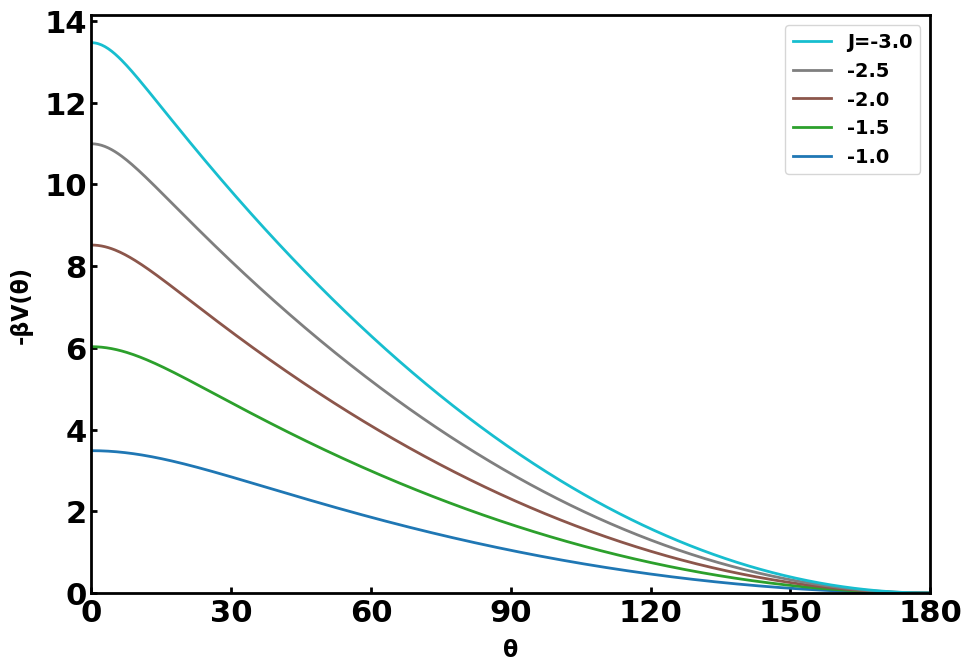

In [79]:
import mpmath as mp

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from lib.renormalization_mp import track_rg_flow as track_rg_flow_mp
from lib.renormalization_np import track_rg_flow as track_rg_flow_np

# Set mpmath precision
mp.dps = 50

# Run RG flow for different parameters using mpmath
params = [(-1.0, -1.0, 0),
          (-1.5, -1.5, 0),
          (-2.0, -2.0, 0),
          (-2.5, -2.5, 0),
          (-3.0, -3.0, 0),
]

coeffs_list = []
for J1, J2, M in params:
    #flow_history = track_rg_flow_mp(J1, J2, M, b=3, d=2, n_max=10, n_steps=10)
    flow_history = track_rg_flow_np(J1, J2, M, b=3, d=2, n_max=20, n_steps=10)
    coeffs_list.append(flow_history[-1])

# Plot all on the same figure
fig2D = plot_2d_potential_energy(
    coeffs_list,
    J_M_list=params,
    mode='energy',
    angle_unit='degrees',
    angle_range_degrees=(0, 180),
    title=None,
    figsize=(10, 7),
    normalize=True,
    align_minima=True
)
plt.show()

In [ ]:
fig2D.savefig(f"energy2D.png", bbox_inches='tight', dpi=200)

## Merge two figures

# 3D Potential u(theta, phi), Energy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_potential_energy(lambda_nm, mode='potential', angle_unit='radians', 
                             angle_range_degrees=(0, 180), reverse_axes=True,
                             title=None, n_points=100, cmap='viridis', show_colorbar=True, 
                             figsize=(10, 8), elev=30, azim=30, normalize=True, 
                             epsilon=1e-15, align_minima=False,
                             J1=None, J2=None, M=None, save_path=None):
    """
    Plot 3D potential or energy reconstructed from Fourier coefficients.
    Works with both numpy and mpmath coefficient arrays.
    
    Args:
        lambda_nm: 2D array of Fourier coefficients
        mode: 'potential' to plot u(θ,φ) or 'energy' to plot -β·V(θ,φ) (default: 'potential')
        angle_unit: 'radians' for [0,π] or 'degrees' for [0,180] (default: 'radians')
        angle_range_degrees: Tuple with min and max angle values in degrees (default: (0, 180))
        reverse_axes: Whether to reverse the direction of the angle axes (default: True)
        title: Title for the plot (default: None)
        n_points: Number of points for the angle grid (default: 100)
        cmap: Colormap for the surface (default: 'viridis')
              Sequential colormaps (from low to high values):
                 'viridis' - Default, perceptually uniform, good for most data
                 'plasma' - Perceptually uniform, yellow to purple
                 'inferno' - Perceptually uniform, yellow to red to black
                 'magma' - Perceptually uniform, white to red to black
                 'cividis' - Color-vision-deficiency-friendly version of viridis
                 'Blues' - White to blue
                 'Greens' - White to green
                 'Reds' - White to red
                 'YlOrBr' - Yellow to orange to brown
                 'YlOrRd' - Yellow to orange to red
                 'OrRd' - Orange to red
                 'PuRd' - Purple to red
                 'BuPu' - Blue to purple
                 'GnBu' - Green to blue
        show_colorbar: Whether to show the colorbar (default: True)
        figsize: Figure size (width, height) in inches (default: (10, 8))
        elev: Elevation angle for 3D view (default: 30)
        azim: Azimuth angle for 3D view (default: 30)
        normalize: Whether to normalize the potential so its maximum value is 1 (default: True)
        epsilon: Small value to avoid log(0) when calculating energy (default: 1e-15)
        align_minima: Whether to shift energy values so minimum is at zero (default: False)
        J1, J2, M: Original model parameters (for reference in title)
        save_path: Path to save the figure (default: None)
        
    Returns:
        fig: Matplotlib figure object
    """
    # Helper function to detect if a value is an mpmath object
    def is_mpmath(x):
        return hasattr(x, '_mpf_') or hasattr(x, '_mpc_')
    
    # Helper function to convert mpmath to float/complex
    def to_numpy_type(x):
        if is_mpmath(x):
            if hasattr(x, '_mpc_'):  # Complex mpmath
                return complex(x)
            else:  # Real mpmath
                return float(x)
        return x  # Already numpy type
    
    # Set angle range based on unit
    if angle_unit.lower() == 'radians':
        angle_range = (0, np.pi)
        xy_label_suffix = ""  # " (radians)"
    else:  # 'degrees'
        angle_range = angle_range_degrees
        xy_label_suffix = ""  # " (degrees)"
    
    # Get the maximum Fourier mode from the coefficient matrix size
    n_max = (lambda_nm.shape[0] - 1) // 2
    
    # Create angle grids - always create in ascending order for calculations
    theta = np.linspace(angle_range[0], angle_range[1], n_points)
    phi = np.linspace(angle_range[0], angle_range[1], n_points)
    THETA, PHI = np.meshgrid(theta, phi)
    
    # Initialize potential
    u = np.zeros_like(THETA, dtype=complex)
    
    # Check if using mpmath
    using_mpmath = False
    if np.any([is_mpmath(x) for x in lambda_nm.flat]):
        using_mpmath = True
    
    # Reconstruct potential by summing over all Fourier modes
    for n in range(-n_max, n_max + 1):
        for m in range(-n_max, n_max + 1):
            n_idx = n + n_max
            m_idx = m + n_max
            
            # Get coefficient (convert from mpmath if needed)
            coeff = lambda_nm[n_idx, m_idx]
            if using_mpmath:
                coeff = to_numpy_type(coeff)
            
            # Convert to radians for calculation if using degrees
            if angle_unit.lower() == 'degrees':
                theta_calc = np.deg2rad(THETA)
                phi_calc = np.deg2rad(PHI)
            else:
                theta_calc = THETA
                phi_calc = PHI
                
            u += coeff * np.exp(1j * (n*theta_calc + m*phi_calc))
    
    # Take magnitude of complex potential
    u_mag = np.abs(u)
    
    # Normalize the potential if requested
    if normalize and mode.lower() == 'potential':
        max_val = np.max(u_mag)
        if max_val > 0:
            u_mag = u_mag / max_val
    
    # Calculate the z-value for plotting based on mode
    if mode.lower() == 'energy':
        # Apply small epsilon to avoid log(0)
        z_values = -np.log(u_mag + epsilon)
        
        # Align minimum to zero if requested
        if align_minima:
            min_energy = np.min(z_values)
            z_values = z_values - min_energy
            z_label = '-βV(θ,φ)'
            plot_title = 'Relative Energy Function'
        else:
            z_label = '-βV(θ,φ)'
            plot_title = 'Energy Function -βV(θ,φ)'
    else:  # 'potential' mode
        z_values = u_mag
        z_label = 'u(θ,φ)' + (' (normalized)' if normalize else '')
        plot_title = 'Potential Function u(θ,φ)' + (' (normalized)' if normalize else '')
    
    # Configure plot styling
    plt.rcParams.update({
        'font.size': 14,
        'axes.linewidth': 2,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 2,
        'ytick.major.width': 2,
        'xtick.major.size': 4,
        'ytick.major.size': 4
    })
    
    # Create the 3D plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # If reversing axes, reverse the data arrays for plotting
    # Note: We calculated the potential using ascending angles, but
    # we can reverse the arrays for display purposes
    if reverse_axes:
        THETA_display = THETA[:, ::-1]  # Reverse columns (theta)
        PHI_display = PHI[::-1, :]      # Reverse rows (phi)
        z_values_display = z_values[::-1, ::-1]  # Reverse both dimensions
    else:
        THETA_display = THETA
        PHI_display = PHI
        z_values_display = z_values
    
    # Plot the surface with possibly reversed data
    surf = ax.plot_surface(THETA_display, PHI_display, z_values_display, 
                           cmap=cm.get_cmap(cmap), 
                           antialiased=True, linewidth=0.5, alpha=0.95)
    
    # Add colorbar if requested
    if show_colorbar:
        cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=15, pad=0.02)
        # No label on colorbar as it duplicates z-axis label
            
    # Set labels with increased font size
    ax.set_xlabel('θ' + xy_label_suffix, fontsize=17, labelpad=15)
    ax.set_ylabel('φ' + xy_label_suffix, fontsize=17, labelpad=15)
    ax.set_zlabel('')  # Clear default label
    ax.text2D(0.02, 0.55, z_label, transform=ax.transAxes, 
              fontsize=17, va='center', ha='center', rotation=90)
    
    if title:
        ax.set_title(title, fontsize=16)
    elif title == 'default':
        ax.set_title(plot_title, fontsize=16)
    else:
        pass
    
    # Set z-axis limits 
    if mode.lower() == 'potential' and normalize:
        ax.set_zlim(0, 1.05)
    elif mode.lower() == 'energy' and align_minima:
        ax.set_zlim(0, ax.get_zlim()[1])  # Start from 0
    
    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Set tick positions and limits based on the preference
    if angle_unit.lower() == 'radians':
        # Create evenly spaced ticks within the range
        tick_positions = np.linspace(angle_range[0], angle_range[1], 5)
        
        # Generate labels for π fractions
        if angle_range == (0, np.pi):
            tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
        else:
            # For custom ranges, format with π notation
            tick_labels = [f'{pos/np.pi:.2f}π' if pos != 0 else '0' for pos in tick_positions]
        
        # Set tick positions
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
        
        # Set axis limits
        if reverse_axes:
            ax.set_xlim(angle_range[1], angle_range[0])
            ax.set_ylim(angle_range[1], angle_range[0])
        else:
            ax.set_xlim(angle_range[0], angle_range[1])
            ax.set_ylim(angle_range[0], angle_range[1])
    else:  # degrees
        # Create evenly spaced ticks within the range
        tick_positions = np.linspace(angle_range[0], angle_range[1], 7)
        
        # Set tick positions
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        
        # Set axis limits
        if reverse_axes:
            ax.set_xlim(angle_range[1], angle_range[0])
            ax.set_ylim(angle_range[1], angle_range[0])
        else:
            ax.set_xlim(angle_range[0], angle_range[1])
            ax.set_ylim(angle_range[0], angle_range[1])
    
    # Make tick labels larger and inward-facing with increased linewidth
    # Manually set zaxis properties since rcParams doesn't support 3D axes directly
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='z', direction='in', width=2, length=4, labelsize=14)
    
    # Adjust layout to better show z-axis label
    plt.tight_layout(pad=3.0)

    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

100%|██████████| 10/10 [00:18<00:00,  1.88s/it]
/var/folders/56/k5k1hn6s4pd9x__t6s6fpclr0000gn/T/ipykernel_5299/286428738.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap(cmap),


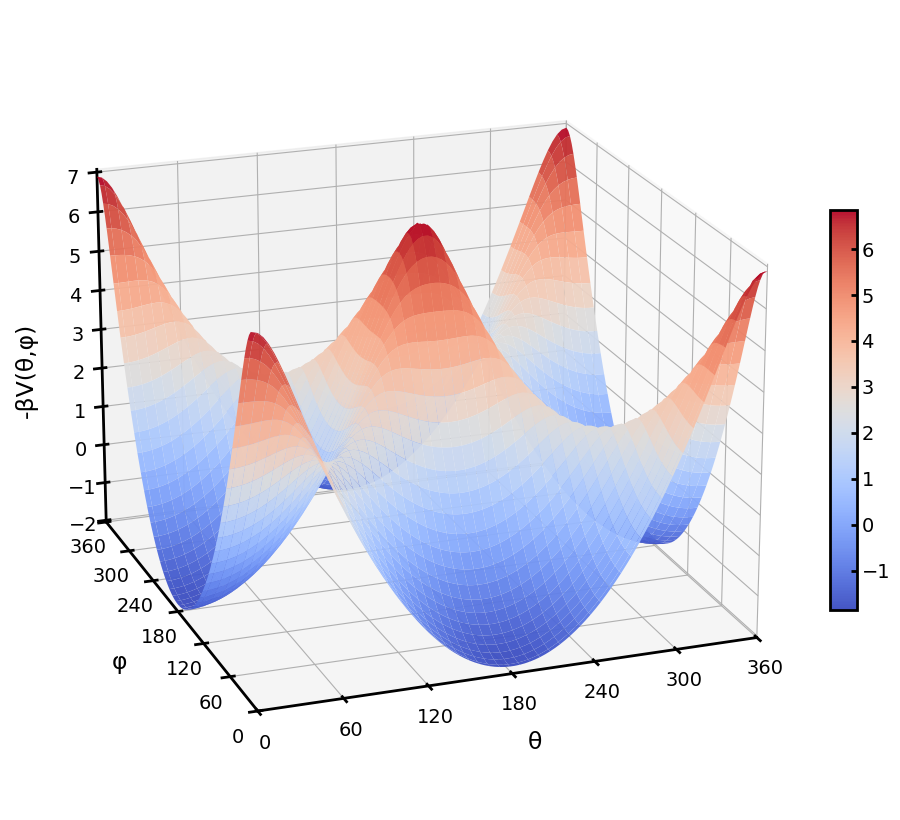

In [54]:
import mpmath as mp

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
#from lib.renormalization_mp import track_rg_flow as track_rg_flow_mp
from lib.renormalization_np import track_rg_flow as track_rg_flow_np

# Set mpmath precision
mp.dps = 50

# Run an RG flow and get final coefficients
J1, J2, M = 0, 0, -2
#flow_history = track_rg_flow_mp(J1, J2, M, b=3, d=2, n_max=10, n_steps=10)
flow_history = track_rg_flow_np(J1, J2, M, b=3, d=2, n_max=20, n_steps=10)
final_coeffs = flow_history[-1]

# Plot energy
fig3D = plot_3d_potential_energy(
    final_coeffs,
    mode='energy',
    angle_unit='degrees',
    angle_range_degrees=(0, 360),
    reverse_axes=True,
    title=None,
    n_points=100,
    cmap='coolwarm',
    show_colorbar=True,
    figsize=(10, 8),
    elev=20, azim=70,
    normalize=False,
    align_minima=False,
    J1=J1, J2=J2, M=M,
    save_path=None,
)
fig3D.tight_layout(pad=0)
plt.show()

In [41]:
fig3D.savefig(f"potential3D_Asigma.png", bbox_inches='tight', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Save and Load Results

In [140]:
import pickle

# Save the list to a file
with open(f'saved_coefficients.pkl', 'wb') as f:
    pickle.dump({
        'coeffs_list': coeffs_list,
        'params': params,
        'n_max': 10,
        'n_steps': 10,
        'version': 'mp'
    }, f)

In [ ]:
# Later, to load the data
with open('saved_coefficients.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    
coeffs_list = saved_data['coeffs_list']
params = saved_data['params']